## Project Udacity Data Engineering Nanodegree

This notebook has been created for debugging the project "Cloud Data Warehouse" within Udacity Nanodegree "Data Engineering (with AWS)". The project was realized within my own AWS account. I have set up an EC2 t2.micro instance (Ubuntu AMI) with 16 GB storage. On this EC2 instance Anaconda3 was installed and Jupyter Notebooks were used for project realization. The notebooks ran in Udacity conda environment were all packages were installed.

### (0) Prepare Python environment

In [3]:
import pandas as pd
import boto3
import json
from time import time
import configparser
import psycopg2
import configparser
import numpy as n
%matplotlib inline
from matplotlib import pyplot as plt

### (1) Load Data Warehouse Configuration

Our planned data warehouse configuration is stored in file "dwh.cfg" which is stored in the same folder as our Jupyter Notebook. We will read cloud infrastructure parameters for our Redshift data warehouse from this file. We will assign these parameters to our data warehouse infrastructure variables.

In [4]:
import configparser
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

In [1]:
#KEY                    = config.get('AWS','KEY')
#SECRET                 = config.get('AWS','SECRET')
ACCOUNTNAME            = config.get('AWS','ACCOUNTNAME')

DWH_CLUSTER_TYPE       = config.get("CLUSTER","DWH_CLUSTER_TYPE")
DWH_NUM_NODES          = config.get("CLUSTER","DWH_NUM_NODES")
DWH_NODE_TYPE          = config.get("CLUSTER","DWH_NODE_TYPE")

DWH_CLUSTER_IDENTIFIER = config.get("CLUSTER","DWH_CLUSTER_IDENTIFIER")
DWH_DB                 = config.get("CLUSTER","DB_NAME")
DWH_DB_USER            = config.get("CLUSTER","DB_USER")
DWH_DB_PASSWORD        = config.get("CLUSTER","DB_PASSWORD")
DWH_PORT               = config.get("CLUSTER","DB_PORT")

DWH_IAM_ROLE_NAME      = config.get("CLUSTER", "DWH_IAM_ROLE_NAME")
MAP_BUCKET             = config.get("S3", "LOG_JSONPATH")
MAP_BUCKET_SONGS       = config.get("S3", "SONG_JSONPATH")


(DWH_DB_USER, DWH_DB_PASSWORD, DWH_DB)

pd.DataFrame({"Param":
                  ["DWH_CLUSTER_TYPE", "DWH_NUM_NODES", "DWH_NODE_TYPE", "DWH_CLUSTER_IDENTIFIER", "DWH_DB", "DWH_DB_USER", "DWH_PORT", "DWH_IAM_ROLE_NAME","LOG_JSONPATH","SONG_JSONPATH"],
              "Value":
                  [DWH_CLUSTER_TYPE, DWH_NUM_NODES, DWH_NODE_TYPE, DWH_CLUSTER_IDENTIFIER, DWH_DB, DWH_DB_USER, DWH_PORT, DWH_IAM_ROLE_NAME,MAP_BUCKET,MAP_BUCKET_SONGS]
             })

NameError: name 'config' is not defined

### (2) Init Clients for AWS

In [7]:
s3 = boto3.resource('s3')

iam = boto3.client('iam')

redshift = boto3.client('redshift',region_name="us-west-2")

### OPTIONAL: Review Mapping

First, we are going to check the mapping definitions.

In [8]:
content_object = s3.Object('udacity-dend', 'log_json_path.json')
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)
df=pd.DataFrame(json_content)
print("Mapping definition for log data: ")
print(df)

Mapping definition for log data: 
             jsonpaths
0          $['artist']
1            $['auth']
2       $['firstName']
3          $['gender']
4   $['itemInSession']
5        $['lastName']
6          $['length']
7           $['level']
8        $['location']
9          $['method']
10           $['page']
11   $['registration']
12      $['sessionId']
13           $['song']
14         $['status']
15             $['ts']
16      $['userAgent']
17         $['userId']


In [9]:
content_object = s3.Object('songmappingudacity', 'JSON_map_songs.json')
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)
df=pd.DataFrame(json_content)
print("Mapping definition for song data: ")
print(df)

Mapping definition for song data: 
               jsonpaths
0         $['num_songs']
1         $['artist_id']
2   $['artist_latitude']
3  $['artist_longitude']
4   $['artist_location']
5       $['artist_name']
6           $['song_id']
7             $['title']
8          $['duration']
9              $['year']


Here we can have a look how the **song data** is structured. One entity is shown for demonstration purposes.

In [10]:
content_object = s3.Object('udacity-dend', 'song_data/A/A/A/TRAAAAK128F9318786.json')
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)
df=pd.DataFrame((json_content),index=[0])
display(df.head())

,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,duration,num_songs,song_id,title,year
0,ARJNIUY12298900C91,None,,None,Adelitas Way,213.9424,1,SOBLFFE12AF72AA5BA,Scream,2009


Here we can have a look how the **log data** is structured. One entity is shown for demonstration purposes.

In [11]:
content_object = s3.Object('udacity-dend', 'log-data/2018/11/2018-11-01-events.json')
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = [json.loads(line) for line in file_content.splitlines()]
df=pd.DataFrame((json_content))
display(df.head(1))

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Walter,M,0,Frye,NaN,free,"San Francisco-Oakland-Hayward, CA",GET,Home,1.540919e+12,38,None,200,1541105830796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",39


### (3) Create Redshift Role in IAM

To read data from S3 data lake "udacity-dend" we need to create a role with the permissions to read data from S3.

In [12]:
try:
    print('Attempt to create IAM role for redshift')
    dwhRole = iam.create_role(
    Path='/',
    RoleName="dwhRole",
    Description="Grant Redshift to access AWS service on our behalf",
    AssumeRolePolicyDocument=json.dumps(
    {'Statement':[{'Action':'sts:AssumeRole',
                  'Effect':'Allow',
                  'Principal':{'Service':'redshift.amazonaws.com'}}],
                  'Version':'2012-10-17'})
    )
    
except Exception as e:
    print(e)

Attempt to create IAM role for redshift
An error occurred (EntityAlreadyExists) when calling the CreateRole operation: Role with name dwhRole already exists.


In [13]:
# TODO: Create the IAM role
try:
    print('1.1 Creating a new IAM Role')
    dwhRole = iam.create_role(
    Path='/',
    RoleName=DWH_IAM_ROLE_NAME,
    Description="Allows Redshift clusters to call AWS services on my behalf.",
    AssumeRolePolicyDocument=json.dumps(
    {'Statement':[{'Action':'sts:AssumeRole',
                  'Effect':'Allow',
                  'Principal':{'Service':'redshift.amazonaws.com'}}],
                  'Version':'2012-10-17'})
    )
    
except Exception as e:
    print(e)

1.1 Creating a new IAM Role
An error occurred (EntityAlreadyExists) when calling the CreateRole operation: Role with name dwhRole already exists.


In [14]:
iam.attach_role_policy(RoleName=DWH_IAM_ROLE_NAME,
                      PolicyArn='arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess',
                      )['ResponseMetadata']['HTTPStatusCode']

print('1.2 Attaching Policy')

1.2 Attaching Policy


In [16]:
print('1.3 Get the IAM role ARN')
roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']

#print(roleArn)

1.3 Get the IAM role ARN


### (4) REDSHIFT: Create Cluster

We create a redshift cluster, set up options are read from file dwh.cfg. We add a role.

#### (4.1) Create Cluster via IaaC

In [13]:
try:
    response = redshift.create_cluster(        
        # Add parameters for hardware
        ClusterType=DWH_CLUSTER_TYPE,
        NodeType=DWH_NODE_TYPE,
        NumberOfNodes=int(DWH_NUM_NODES),

        # Add parameters for identifiers & credentials
        DBName=DWH_DB,
        ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
        MasterUsername=DWH_DB_USER,
        MasterUserPassword=DWH_DB_PASSWORD,
        
        # Add parameter for role (to allow s3 access)
        IamRoles=[roleArn]
    )
except Exception as e:
    print(e)

An error occurred (ClusterAlreadyExists) when calling the CreateCluster operation: Cluster already exists


#### (4.2) Check Status of DWH Creation

In [17]:
def prettyRedshiftProps(props):
    pd.set_option('display.max_colwidth', None)
    #pd.set_option('display.max_colwidth', -1)
    keysToShow = ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId',"Region"]
    x = [(k, v) for k,v in props.items() if k in keysToShow]
    return pd.DataFrame(data=x, columns=["Key", "Value"])

myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
#prettyRedshiftProps(myClusterProps)

### (5) Get Endpoint/Role/Connection String for DB Connection

In [18]:
DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']
#print("DWH_ENDPOINT :: ", DWH_ENDPOINT)
#print("DWH_ROLE_ARN :: ", roleArn)

In [16]:
%load_ext sql

In [19]:
conn_string="postgresql://{}:{}@{}:{}/{}".format(DWH_DB_USER, DWH_DB_PASSWORD, DWH_ENDPOINT, DWH_PORT,DWH_DB)
#print("You can connect to the Redshift database using the following string: ")
#print(conn_string)

### (6) Explore Information about Kind of Raw Data in Data Lake

### (6-1) List Raw Data Files in Bucket

Here the names of the buckets in which data is stored are listed (data lake).

In [18]:
s3_path_song="s3://udacity-dend/song_data"
s3_path_log="s3://udacity-dend/log_data"

In [19]:
bucket = s3_path_song.split('//')[1].split('/')[0]
songPrefix = '/'.join(s3_path_song.split('//')[1].split('/')[1:])
logPrefix = '/'.join(s3_path_log.split('//')[1].split('/')[1:])

The data lake (bucket) contains all data. Data can be split in log files (**logPrefix**) and song files (**songPrefix**).

In [20]:
print(bucket)
print(songPrefix)
print(logPrefix)

udacity-dend
song_data
log_data


All objects in the data lake can be listed here:

In [21]:
songBucket =  s3.Bucket("udacity-dend")

print("The name of the bucket requested is: "+str(bucket))
print("Starting to explore bucket content ...")

#Iterate over bucket objects starting with "song_data/" and print
file_list=[]
file_type_list=[]
n=0
for obj in songBucket.objects.filter(Prefix="song_data/"):
    if n>0:
        file_type_list.append('song_data')
        file_list.append(obj.key)
    n=n+1

n=0   
for obj in songBucket.objects.filter(Prefix="log_data/"):
    if n>0:
        file_type_list.append('log_data')
        file_list.append(obj.key)
    n=n+1

print("Bucket content successfully scanned.")

The name of the bucket requested is: udacity-dend
Starting to explore bucket content ...
Bucket content successfully scanned.


In [22]:
print("Here is a list of all log/song files found in your bucket:")
df_file=pd.DataFrame()
df_file['data type']=file_type_list
df_file['file']=file_list
display(df_file)
print("There are "+str(len(df_file)) + " files in your data lake for processing.")

Here is a list of all log/song files found in your bucket:


,data type,file
0,song_data,song_data/A/A/A/TRAAAAK128F9318786.json
1,song_data,song_data/A/A/A/TRAAAAV128F421A322.json
2,song_data,song_data/A/A/A/TRAAABD128F429CF47.json
3,song_data,song_data/A/A/A/TRAAACN128F9355673.json
4,song_data,song_data/A/A/A/TRAAAEA128F935A30D.json
...,...,...
14921,log_data,log_data/2018/11/2018-11-26-events.json
14922,log_data,log_data/2018/11/2018-11-27-events.json
14923,log_data,log_data/2018/11/2018-11-28-events.json
14924,log_data,log_data/2018/11/2018-11-29-events.json


There are 14926 files in your data lake for processing.


### (6-2) OPTIONAL: Read files and Print Data Size

Here we can check the size of the raw data in the S3 bucket(s):

In [23]:
#size_byte=0
#my_bucket=songBucket
#for my_bucket_object in my_bucket.objects.all():
    #print(my_bucket_object.key)
    #size_byte=size_byte+my_bucket_object.size
    #totalsize_gb=size_byte/1000/1024/1024
#print("Size of all files in your data lake is " +str(totalsize_gb) + " GB.")

### (7) REDSHIFT: ETL Tests

#### (7.1) Create final tables (star schema)

In [24]:
from sql_queries import create_table_queries, drop_table_queries
%run create_tables.py
print("Redshift star schema final tables successfully created.")

Redshift star schema final tables successfully created.


Read data for database connection to Redshift from configuration file. Create connection and init cursor.

In [25]:
config = configparser.ConfigParser()
config.read('dwh.cfg')

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

print("Database connection started.")

Database connection started.


#### (7.2) Load Data from Datalake to Staging Tables

Load data from raw data files (datalake) to staging tables. 

In [26]:
def load_staging_tables(cur, conn):
    for query in copy_table_queries:
        cur.execute(query)
        conn.commit()

In [27]:
from sql_queries import copy_table_queries
load_staging_tables(cur, conn)
print("Data successfully loaded from data lake to staging tables.")

Data successfully loaded from data lake to staging tables.


#### (7.3) Insert Data from Staging Tables to Final Tables

Insert data from staging tables to final tables (star schema).

In [28]:
def insert_tables(cur, conn):
    for query in insert_table_queries:
        cur.execute(query)
        conn.commit()

In [29]:
from sql_queries import insert_table_queries
insert_tables(cur,conn)
print("Data successfully inserted from staging tables to final tables.")

Data successfully inserted from staging tables to final tables.


### (8)  Redshift: ETL Pipeline

Now, all modules are put together to a complete ETL pipeline.

In [ ]:
%run create_tables.py
%run etl.py

In [ ]:
print ("Loaded data via ETL pipeline successfully.")

### (9) Analytics with Data Warehouse Data

Now you can work with the data loaded into your Cloud DWH and execute some queries. All queries are executed via script *analytics.py*.

#### (9.1) Execute Query Statements

In [18]:
%run analytics.py

[[('Osanna', Decimal('1108')), ('William Shatner_ David Itkin_ The Arkansas Symphony Orchestra_ Paul Rowe', Decimal('1047')), ('Polygon Window', Decimal('1033')), ('Aphex Twin', Decimal('1033')), ('Mastodon', Decimal('887')), ('Frankie Goes To Hollywood', Decimal('821')), ('Pearl Jam', Decimal('780')), ('SPEEDY J/CHRIS LIEBING', Decimal('768')), ('Cult Of Luna', Decimal('683')), ('Fertile Ground', Decimal('661'))], [('Black Eyed Peas', 2), ('Chuck Loeb', 2), ('Hayseed Dixie', 2), ('Jag Panzer', 2), ('Jamie Cullum', 2), ('Karunesh', 2), ('Lil Scrappy / Homeboy', 2), ('Linda Eder', 2), ('Mastodon', 2), ('Pearl Jam', 2), ('Polygon Window', 4), ('The (International) Noise Conspiracy', 2), ('The Kooks', 2), ('Tracy Chapman', 2), ('Tweeterfriendly Music', 2), ('Xcultures', 2)]]


Results will be saved as a csv file on your EC2 instance in the notebook folder.

#### (9.2) Read Data and Visualize It

We will take the first query in chapter **Analytic Queries** in our *sql_queries.py* file. This query sums up the durations of all songs of one artist and then sorts from top to bottom. Top is the artist with the most time available songplay in seconds, bottonm the least.

In [90]:
results=pd.read_csv("analytics.csv")

In [109]:
def extract_viz_data(results):
    """
    Function:
        Extracts data from our query results in analytics.py and makes them
        ready for being plotted.
    Args:
        results: Returned data by our queries.
    Returns:
        List of artists ready for plotting, list of available time per artist ready for plotting.
    """
    list_artists=[]
    list_minutes=[]
    for n in range(0,len(results.columns)):
        if str(results.iloc[0,n])[:1]=="(":
            x = results.iloc[0,n].split(",")
            y=x[0][:-1]
            list_artists.append(x[0][2:-1])
            list_minutes_val=int(x[1][8:-1].replace(")","").replace("(","").replace("'",""))
            list_minutes.append(list_minutes_val)
    return list_artists,list_minutes

In [110]:
list_artists,list_minutes = extract_viz_data(results)

Text(0.5, 1.0, 'Top 10 Artists with longest songplay time available on Sparkify [sec]')

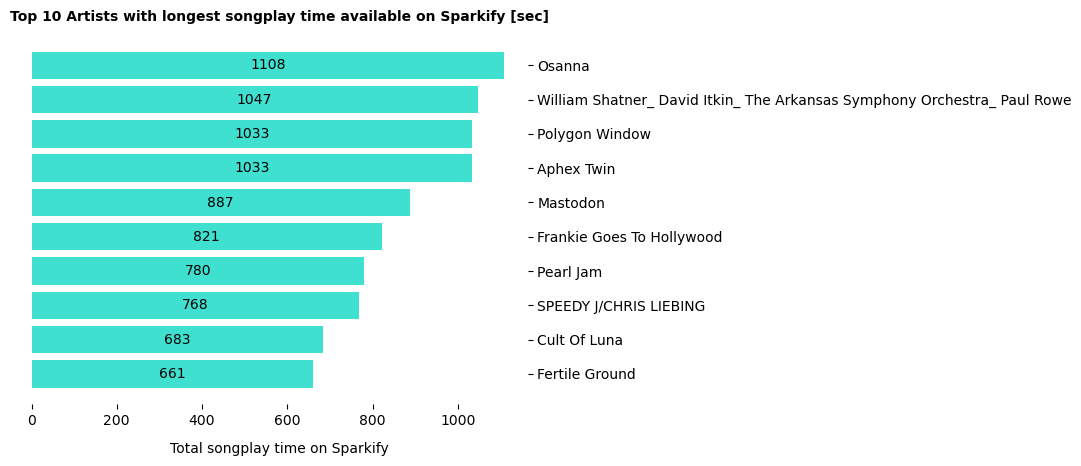

In [195]:
def plot_songplaytime_data(list_minutes,list_artists):
    """
    Function:
        Plots available songplay time in seconds as a horizontal bar chart.
    Args:
        results: Returned data by our queries, cleaned via function extract_viz_data
    Returns:
        None
    """
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(list_minutes))
    viz=ax.barh(list_artists, list_minutes,color="turquoise")
    ax.set_yticks(y_pos,labels=list_artists)
    ax.yaxis.tick_right() 
    ax.bar_label(viz, fmt='%.0f',label_type="center",color="black")
    ax.set_xlabel('Total songplay time on Sparkify',fontsize=10,labelpad=10)
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title('Top 10 Artists with longest songplay time available on Sparkify [sec]',fontweight='bold',fontsize=10,pad=10)

### (9) Close Connection

In [ ]:
conn.close()

In [ ]:
print("Connection to database closed.")